# Reconstruction using top eigen-vectors

## Load the required libraries

In [1]:
# Enable automiatic reload of libraries
%load_ext autoreload
%autoreload 2 # means that all modules are reloaded before every command

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.path.append('./lib')
from import_modules import import_modules,modules
import_modules(modules)

from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions
from recon_plot import recon_plot
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter

    pandas as    pd 	version=0.19.2 	required version>=0.19.2
     numpy as    np 	version=1.12.0 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
module pyspark has no version


In [4]:
from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [5]:
data_dir='../../Data/Weather'
file_index='BBBSBBBB'

In [6]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame

In [7]:
#read data
filename=data_dir+'/US_Weather_BBBSBBBB.csv'
List=load(open(filename,'rb'))
print 'length of List=',len(List)

df=sqlContext.createDataFrame(List)
print df.count()
df.show(5)

length of List= 13047
13047
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[80 4D 00 46 E0 5...|1931.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     0|[00 4F 80 51 00 4...|1932.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[20 D0 00 53 A0 5...|1933.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     2|[30 55 80 C9 A0 D...|1934.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       TMAX|USC00198301|     1|[E0 50 00 CF 00 5...|1935.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



## Look at some examples

In [8]:
m='SNWD'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%(m)
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)

SELECT * FROM weather
	WHERE measurement='SNWD'
1321 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       SNWD|USC00198301|     2|[00 00 00 00 00 0...|1949.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       SNWD|USC00198301|    30|[00 00 00 00 00 0...|1950.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



### Create a matrix with all of the series

In [9]:
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T # scaling to make the temperature be in centingrates
shape(T)

(1321, 365)

### Plot two time series
`SNWD` stands for `snow-depth`, which explains why it is zero during the summer

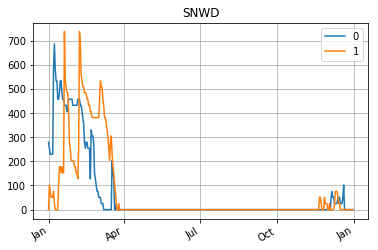

In [10]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(6,4));
YP=YearPlotter()
YP.plot(T[16:18].transpose(),fig,ax,title=m)

### Plot Reconstructions

Construct approximations of a time series using the mean and the $k$ top eigen-vectors
First, we plot the mean and the top $k$ eigenvectors

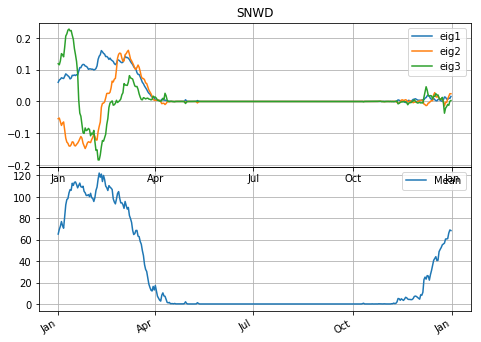

In [11]:
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
fig=plt.figure(figsize=(6,4))
ax=fig.add_axes([0,0,1,.5])
YearPlotter().plot(Mean,fig,ax,label='Mean',title=m)
ax=fig.add_axes([0,.5,1,.5])
YearPlotter().plot(EigVec,fig,ax,title=m,labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

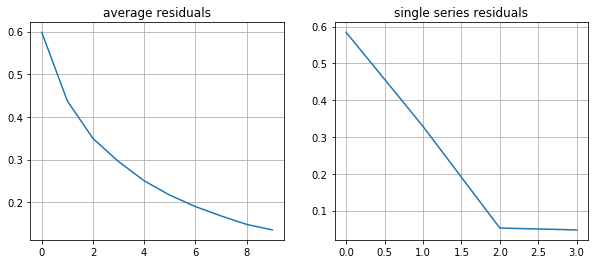

In [12]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
figure(figsize=[10,4]); subplot(121)
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals)
plot(1-cumvar[:10]); grid(); title('average residuals')
subplot(122)
v=[np.array(EigVec[:,i]).flatten() for i in range(shape(EigVec)[1])]
target=T[16,:]
eigen_decomp=Eigen_decomp(None,target,Mean,v)
total_var,residuals,reductions,_coeff=eigen_decomp.compute_var_explained()
plot(list(residuals[1])); grid(); title('single series residuals');

## Interactive plot of reconstruction

Following is an interactive widget which lets you change the coefficients of the eigen-vectors to see the effect on the approximation.
The initial state of the sliders (in the middle) corresponds to the optimal setting. You can zero a positive coefficient by moving the slider all the way down, zero a negative coefficient by moving it all the way up.

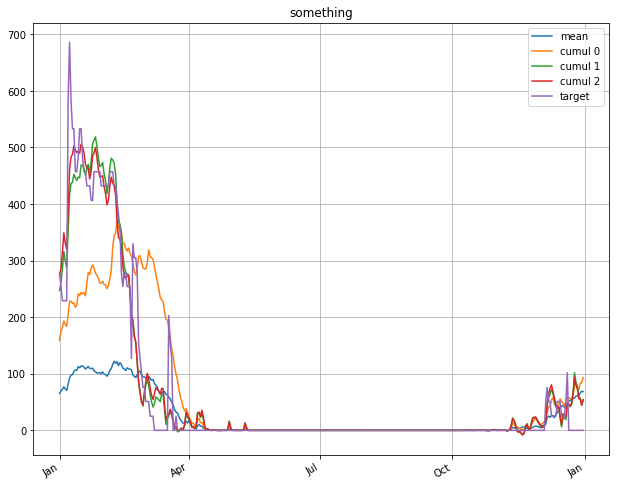

In [14]:
from recon_plot import recon_plot
from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
import numpy as np
from ipywidgets import interactive,widgets
from recon_plot import recon_plot
plotter=recon_plot(eigen_decomp,year_axis=True,interactive=True,Title='something')
widge_list,widge_dict = plotter.get_widgets()
interactive(plotter.plot_combination, **widge_dict)
widgets.VBox([widgets.HBox(widge_list)])

## Process whole dataframe to find best and worse residuals

In [15]:
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%(m)
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
shape(T)

SELECT * FROM weather
	WHERE measurement='SNWD'
1321 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      6.1| 42.4667|    -70.9|       SNWD|USC00198301|     2|[00 00 00 00 00 0...|1949.0|BBBSBBBB|
|      6.1| 42.4667|    -70.9|       SNWD|USC00198301|    30|[00 00 00 00 00 0...|1950.0|BBBSBBBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(1321, 365)

### Add to each row in the dataframe a residual values 
Residuals are after subtracting in sequence: the mean, the projection on the first eigen-vector the projection on the second eigen-vector etc.

`decompose(row)` axtracts the series from the row, computes the residuals and constructs a new row that is reassembled into a dataframe.

A more efficient solution would be to use UDFs (user defined functions) but I could not make it work.

In [16]:
def decompose(row):
    Series=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    recon=Eigen_decomp(None,Series,Mean,v);
    total_var,residuals,reductions,coeff=recon.compute_var_explained()
    #print coeff
    residuals=[float(r) for r in residuals[1]]
    coeff=[float(r) for r in coeff[1]]
    D=row.asDict()
    D['total_var']=float(total_var[1])
    D['res_mean']=residuals[0]
    for i in range(1,len(residuals)):
        D['res_'+str(i)]=residuals[i]
        D['coeff_'+str(i)]=coeff[i-1]
    return Row(**D)  

In [17]:
#import numpy
rdd2=df1.rdd.map(decompose)
df2=sqlContext.createDataFrame(rdd2)
df2.select('res_mean','res_1','res_2','res_3','total_var','coeff_1','coeff_2','coeff_3').show(3)

+------------------+------------------+------------------+------------------+---------+------------------+------------------+------------------+
|          res_mean|             res_1|             res_2|             res_3|total_var|           coeff_1|           coeff_2|           coeff_3|
+------------------+------------------+------------------+------------------+---------+------------------+------------------+------------------+
| 2.209955432620985| 1.046814308319828|0.9581280375380435|0.8865782778918574| 298128.0|-598.3249940170076|161.76994189194897|-145.3588245004226|
| 2.284385322885889| 1.072236833604479|0.7114781562741938|0.6649519657554572| 218884.0|-616.0433321092116|233.20845084642053| -133.766535334883|
|1.7073099575975323|0.6619932455988242|0.6561226743917165|0.6141369472697049| 404427.0|-671.8168941500662|-41.12668707493687|105.69721009416432|
+------------------+------------------+------------------+------------------+---------+------------------+------------------+-----

In [31]:
def plot_decomp(row,Mean,v,fig=None,ax=None,Title=None,interactive=False):
    target=np.array(unpackArray(row.vector,np.float16),dtype=np.float64)
    if Title is None:
        Title='%s / %d    %s'%(row['station'],row['year'],row['measurement'])
    eigen_decomp=Eigen_decomp(None,target,Mean,v)
    plotter=recon_plot(eigen_decomp,year_axis=True,fig=fig,ax=ax,interactive=interactive,Title=Title)
    return plotter


In [32]:
row,=df2.take(1)

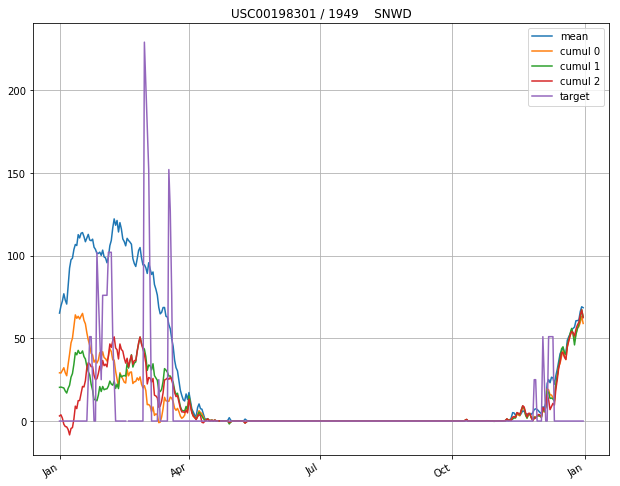

In [36]:
plotter=plot_decomp(row,Mean,v,interactive=True);
widge_list,widge_dict = plotter.get_widgets()
interactive(plotter.plot_combination, **widge_dict)
widgets.VBox([widgets.HBox(widge_list)])

In [21]:
print 'before filter',df2.count()
df3=df2.filter(df2.total_var!=0)
print 'after filter',df3.count()

before filter 1321
after filter 1306


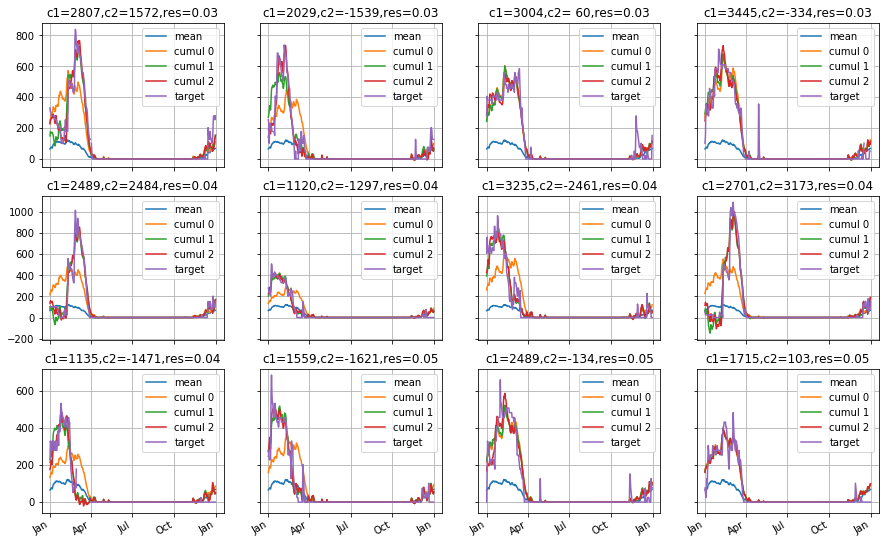

In [37]:
#def plot_recon_grid(rows,column_n=4, row_n=3, figsize=(15,10)):
column_n=4; row_n=3; figsize=(15,10)
fig,axes=plt.subplots(row_n,column_n, sharex='col', sharey='row',figsize=figsize);
k=0
for i in range(row_n):
    for j in range(column_n):
        row=rows[k]
        k+=1
        _title='c1=%3.0f,c2=%3.0f,res=%3.2f'%(row['coeff_1'],row['coeff_2'],row['res_3'])
        plot_decomp(row,Mean,v,fig=fig,ax=axes[i,j],Title=_title,interactive=False)

In [39]:
df3=df3.sort(df3.res_3,ascending=True)
rows=df3.take(12)

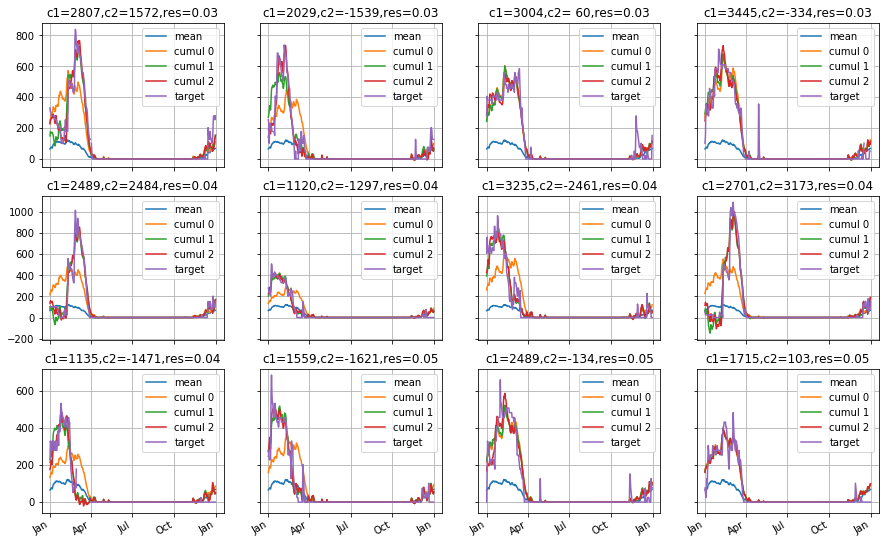

In [41]:
plot_recon_grid(rows)

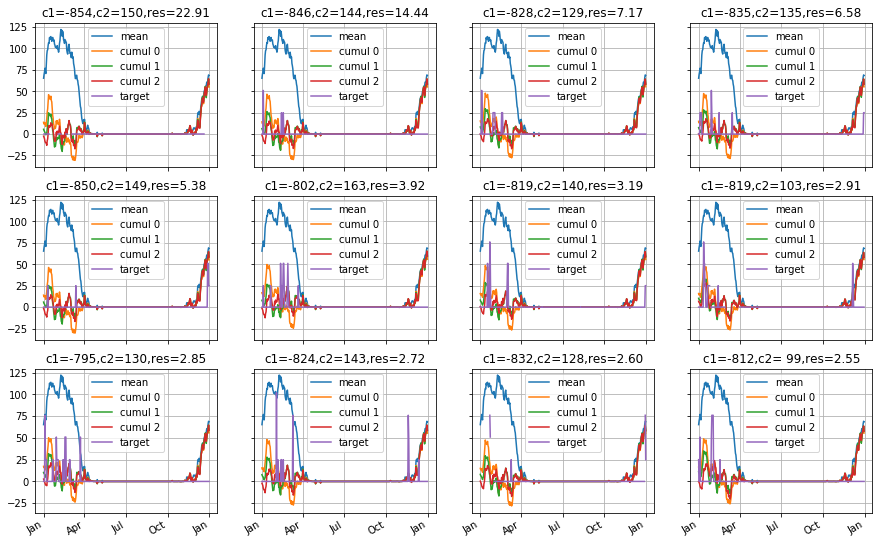

In [42]:
df3=df3.sort(df3.res_3,ascending=False)
rows=df3.take(12)
plot_recon_grid(rows)

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [48]:
res3=df3.select('res_3').collect()
R3=[r['res_3'] for r in res3]

len(R3)

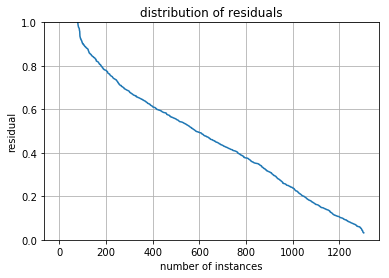

In [63]:
plot(R3)
title('distribution of residuals')
xlabel('number of instances')
ylabel('residual')
ylim([0,1])
grid()

In [65]:
print df3.count(),
df4=df3.filter(df3.res_3<0.5)
print '->',df4.count()

1306 -> 721


In [66]:
c=df4.select('coeff_1').collect()
c1=[x['coeff_1'] for x in c]
c=df4.select('coeff_2').collect()
c2=[x['coeff_2'] for x in c]
c1[:4],c2[:4]

([-357.61369836678693,
  -290.2003248148207,
  -727.7660767231614,
  -169.7820089882909],
 [333.4635575257431,
  -101.03257492369848,
  31.022503070523648,
  -411.71993505226175])

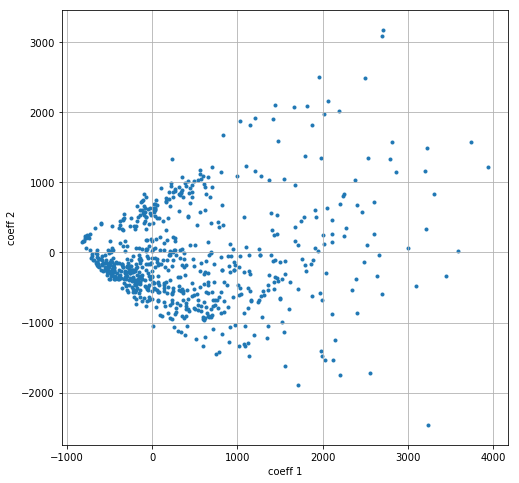

In [67]:
figure(figsize=(8,8))
scatter(c1,c2,marker='.')
xlabel('coeff 1')
ylabel('coeff 2')
grid()

In [72]:
df3.write.parquet(data_dir+'/decon_'+file_index+'.parquet')

In [71]:
data_dir

'../../Data/Weather'

In [73]:
!ls -lrt $data_dir

total 1226808
-rw-r--r--    1 yoavfreund  staff  417856543 Mar  6 13:38 SampleStations.pickle
-rw-r--r--    1 yoavfreund  staff    2816937 Mar  6 13:52 stations_projections.pickle
-rw-r--r--    1 yoavfreund  staff   13888914 Mar  6 13:52 stations.pkl
-rw-r--r--    1 yoavfreund  staff     210335 Mar  6 13:52 stable-clusters.pickle
-rw-r--r--    1 yoavfreund  staff        270 Mar  6 13:52 ghcnd-version.txt
-rw-r--r--    1 yoavfreund  staff    7760844 Mar  6 13:52 ghcnd-stations_buffered.txt
-rw-r--r--    1 yoavfreund  staff    8357832 Mar  6 13:52 ghcnd-stations.txt
-rw-r--r--    1 yoavfreund  staff      22422 Mar  6 13:52 ghcnd-readme.txt
-rw-r--r--    1 yoavfreund  staff        218 Mar  6 13:52 data-source.txt
-rw-r--r--    1 yoavfreund  staff        243 Mar  9 20:56 STAT1.pickle
-rw-r--r--    1 yoavfreund  staff   81681132 Mar  9 21:05 STAT.pickle
-rw-r--r--    1 yoavfreund  staff   82276653 Mar 14 18:45 STAT_BBBSBBBB.pickle
-rw-r--r--    1 yoavfreund  staff   13222287 Mar 14 19:01 US

In [76]:
!du -sh $data_dir/*

 78M	../../Data/Weather/STAT.pickle
4.0K	../../Data/Weather/STAT1.pickle
 78M	../../Data/Weather/STAT_BBBSBBBB.pickle
398M	../../Data/Weather/SampleStations.pickle
 13M	../../Data/Weather/US_Weather_BBBSBBBB.csv
4.0K	../../Data/Weather/data-source.txt
3.0M	../../Data/Weather/decon_BBBSBBBB.parquet
 24K	../../Data/Weather/ghcnd-readme.txt
8.0M	../../Data/Weather/ghcnd-stations.txt
7.4M	../../Data/Weather/ghcnd-stations_buffered.txt
4.0K	../../Data/Weather/ghcnd-version.txt
208K	../../Data/Weather/stable-clusters.pickle
 13M	../../Data/Weather/stations.pkl
2.7M	../../Data/Weather/stations_projections.pickle
